DESCRIPCIÓN DEL PROYECTO

Zyfra, compañía de minería de oro, requiere un modelo de predicción de oro extraído. 

Los datos de prueba carecen de algunas medidas entre ellas las concentraciones y rendimiento de extracción de oro. 

Objetivo: 

A partir de los datos de prueba predecir los valores de recuperación, evaluando la fidelidad de la predicción y presentar los valores.

Reporte de Resultados: 

Se llegó a una predicción con 5.38% de variación promedio de los valores reales. Datos presentados al final del proyecto. 

In [1]:
#Configuración de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ML
import sklearn
from sklearn.impute import KNNImputer #imputador
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression #modelo
from sklearn.metrics import make_scorer, mean_absolute_error #Evaluación de la regresión
from sklearn.utils import shuffle #Reordenar datos
from sklearn.ensemble import RandomForestRegressor

#Opcionales. 
from sklearn.pipeline import Pipeline #Automatizar

Importación y Exploración de datos

In [2]:
datos_fuente = pd.read_csv("/datasets/gold_recovery_full.csv")
datos_entrenamiento = pd.read_csv("/datasets/gold_recovery_train.csv")
datos_prueba = pd.read_csv("/datasets/gold_recovery_test.csv")

In [3]:
#DEA
#Revisión de tipos de datos, dimensionalidad, presencia de nulos. 
datos_fuente.info() #22716 registros, 87 columnas
datos_entrenamiento.info() #16860 registros, 87.
datos_prueba.info() #5856 registros, 53 columnas. Qué le pasó a las columnas?

print("Todas las columnas son float o numéricos a excepción de fecha que es un objeto podiendo ser datetime. \nHay presencia de nulos.") 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
#Exploración de los datos

print(datos_fuente.head())
print(datos_fuente.shape)

#print(datos_entrenamiento.head()) 
#print(datos_prueba.head()) #Toma mucho espacio en formar los resultados. No genera mucha información relevante.


#Cambio de dato a tipo datetime.
#Modificar date a formato fecha
datos_fuente["date"] = pd.to_datetime(datos_fuente["date"])
datos_entrenamiento["date"] = pd.to_datetime(datos_entrenamiento["date"])
datos_prueba["date"] = pd.to_datetime(datos_prueba["date"])

#Exploración de rango de valores en fecha. 
print(datos_fuente["date"].min(), datos_fuente["date"].max()) #datos provenientes desde inicio del año 2016 hasta el mes 8 o agosto del año 2018.
print("Datos provenientes desde inicio del año 2016 hasta el mes 8 o agosto del año 2018.")
print()
print(datos_entrenamiento["date"].min(), datos_entrenamiento["date"].max()) #conservado en datos de entrenamiento. 
print(datos_prueba["date"].min(), datos_prueba["date"].max())
print("\nLos datos de entrenamiento mantienen el mismo rango de registro de fecha que los datos totales o fuente. Los datos prueba por otra parte inician en el mes 9 de 2016 y concluyen en el mes 12 de 2017.") 

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [5]:
#Exploración y Manejo de nulos 
print("\nDatos nulos mayor a 10% en datos fuente:")
tasa_na_fuente = datos_fuente.isna().mean()
tasa_na_fuente = tasa_na_fuente[tasa_na_fuente>0.1]
print(tasa_na_fuente.to_string()) #4 valores con más de 10% de nulos en datos completos. 

print("\nDatos nulos mayor a 10% en datos entrenamiento.")
tasa_na_entrenamiento = datos_entrenamiento.isna().mean()
tasa_na_entrenamiento = tasa_na_entrenamiento[tasa_na_entrenamiento>0.1]
print(tasa_na_entrenamiento.to_string())

print("\nDatos nulos mayor a 10% en datos prueba.")
tasa_na_prueba = datos_prueba.isna().mean()
tasa_na_prueba = tasa_na_prueba[tasa_na_prueba>0.1]
print(tasa_na_prueba.to_string())
print("No hay. Por eso hay un objeto series vacío.")

#Datos numéricos para imputar
datos_entrenamiento_numericos = datos_entrenamiento.select_dtypes(include=['number'])


Datos nulos mayor a 10% en datos fuente:
rougher.output.recovery    0.137304
rougher.output.tail_ag     0.120488
rougher.output.tail_sol    0.120444
rougher.output.tail_au     0.120444

Datos nulos mayor a 10% en datos entrenamiento.
rougher.input.floatbank11_xanthate    0.112930
rougher.output.recovery               0.152610
rougher.output.tail_ag                0.133452
rougher.output.tail_sol               0.133393
rougher.output.tail_au                0.133393
secondary_cleaner.output.tail_sol     0.117794

Datos nulos mayor a 10% en datos prueba.
Series([], )
No hay. Por eso hay un objeto series vacío.


In [9]:
#Adicion de calculo antes de imputacion
#columnas relevantes a recuperación de oro
datos_entrenamiento_au = datos_entrenamiento.filter(regex='au|final.output.recovery|rougher.output.recovery', axis=1) #selecciona columnas con oro y recuperación final. 
datos_entrenamiento_au.columns
datos_entrenamiento_au = datos_entrenamiento_au.loc[:, ~datos_entrenamiento_au.columns.str.contains('floatbank')]
datos_entrenamiento_au = datos_entrenamiento_au.drop(columns=["rougher.calculation.sulfate_to_au_concentrate", 'rougher.calculation.au_pb_ratio'])
print(datos_entrenamiento_au.columns)

#Solo quedan los concentrados, colas, oro antes de proceso (input.feed)
#Cuantos de cada uno? 
display(datos_entrenamiento_au.head()) 
#Se podrían ordenar para respetar la lógica de los procesos. Rougher antes que primary antes que secondary y final. 

Index(['final.output.concentrate_au', 'final.output.recovery',
       'final.output.tail_au', 'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_au', 'secondary_cleaner.output.tail_au'],
      dtype='object')


,final.output.concentrate_au,final.output.recovery,final.output.tail_au,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_au,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_au,secondary_cleaner.output.tail_au
0,42.192020,70.541216,2.143149,34.174427,2.106679,6.486150,19.793808,87.107763,1.170244,2.606185
1,42.701629,69.266198,2.224930,34.118526,2.353017,6.478583,20.050975,86.843261,1.184827,2.488248
2,42.657501,68.116445,2.257889,33.969464,2.416800,6.362222,19.737170,86.842308,1.162562,2.458187
3,42.689819,68.347543,2.146849,28.260743,2.262051,6.118189,19.320810,87.226430,1.079755,2.322062
4,42.774141,66.927016,2.055292,33.044932,2.277073,5.663707,19.216101,86.688794,1.012642,2.330448


In [10]:
#formula de recuperación: R = (C * (F-T))/(F*(C-T))
#T son colas, F son input, C concentrados. Hay 4 colas output.tail_au (T); Un F o input.feed_au; 4 concentrados 

F = datos_entrenamiento_au["rougher.input.feed_au"]
T = datos_entrenamiento_au["rougher.output.tail_au"]
#final.tail_au y T debe dar similar. 
print("\nDatos de materia prima de entrada:")
display(F.head())
print("\nDatos de restos colaterales de entrada:")
display(T.head())
print("\nDatos de restos finales:")
display(datos_entrenamiento_au["final.output.tail_au"].head()) #"No dan igual, se suman todos?"

C = datos_entrenamiento_au["rougher.output.concentrate_au"]
#final.output.concentrate_au debe dar similar a los output de concentrados previos sumados. 
print("\nConcentrados de flotado de Au:")
display(C.head()) #No son los mismos ni con sort. 
print("\nDatos de concentrados finales de Au:")
display(datos_entrenamiento_au["final.output.concentrate_au"].head())


Datos de materia prima de entrada:


0    6.486150
1    6.478583
2    6.362222
3    6.118189
4    5.663707
Name: rougher.input.feed_au, dtype: float64


Datos de restos colaterales de entrada:


0    1.170244
1    1.184827
2    1.162562
3    1.079755
4    1.012642
Name: rougher.output.tail_au, dtype: float64


Datos de restos finales:


0    2.143149
1    2.224930
2    2.257889
3    2.146849
4    2.055292
Name: final.output.tail_au, dtype: float64


Concentrados de flotado de Au:


0    19.793808
1    20.050975
2    19.737170
3    19.320810
4    19.216101
Name: rougher.output.concentrate_au, dtype: float64


Datos de concentrados finales de Au:


0    42.192020
1    42.701629
2    42.657501
3    42.689819
4    42.774141
Name: final.output.concentrate_au, dtype: float64

In [12]:
#Calculo de recuperación y comparación con recuperación reportada. 
#R = C * (F-T)/(F*(C-T))*100
print(datos_entrenamiento_au["rougher.output.recovery"].head())
print()

#Exploración de tendencia central. Promedio de recuperación de oro de datos reales del set de entrenamiento. 
print("Promedio de recuperación de oro de datos reales del set de entrenamiento:")
print(datos_entrenamiento_au["rougher.output.recovery"].mean()) #68 de promedio. Interesante ver si la tendencia central predecida del set de prueba es cercano. 

print() #Espacio por estética de resultados. 

datos_entrenamiento_au["recovery_calculation"] = C*(F-T)/(F*(C-T))*100
print(datos_entrenamiento_au["recovery_calculation"].head())

#MAE de cálculo de recuperación 
recuperacion_real = datos_entrenamiento_au["rougher.output.recovery"]
recuperacion_calculada = datos_entrenamiento_au["recovery_calculation"]
#Evitar errores por datos nulos
mask_no_nan = recuperacion_real.notna() & recuperacion_calculada.notna()
mae = mean_absolute_error(recuperacion_real[mask_no_nan], recuperacion_calculada[mask_no_nan])
print("MAE:", mae)
print("El promedio de valores de recuperacion de oro es de 82.3 unidad desconocida. Los valores entre los calculados y los reales varían en 9.3 unidades, un 11.3%.")


0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

Promedio de recuperación de oro de datos reales del set de entrenamiento:
82.39420120842001

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: recovery_calculation, dtype: float64
MAE: 9.303415616264301e-15
El promedio de valores de recuperacion de oro es de 82.3 unidad desconocida. Los valores entre los calculados y los reales varían en 9.3 unidades, un 11.3%.


In [9]:
#Eliminación de nulos
#Rellenar nulos de los datos de entrenamiento. Knn Imputer
knn_imputer = KNNImputer(n_neighbors=2)

#entrenar el imputador
#Son 16860 registros y 85 columnas. Los datos son pesados y ocuparían muchos recursos computacionales para entrenar el modelo de imputación así que se hará una muestra
muestra_imputado = datos_entrenamiento_numericos.sample(frac=0.5, random_state=54321) #Solo se usarían la mitad de los datos 8430 filas. 
#Se pierde un poco de precisión por no haber acceso a todos los vecinos pero se usan menos recursos. Pasó de 29 segundos a 12 en mi ordenador. 

knn_imputer.fit(muestra_imputado)
#imputar el set de entrenamiento. Solo las columnas numéricas
datos_entrenamiento_sin_nulos = knn_imputer.transform(datos_entrenamiento_numericos)


In [10]:
#Unir el dataframe de regreso con las fechas
datos_entrenamiento_datetime = datos_entrenamiento.select_dtypes(include=['datetime'])
datos_numericos_imputados = pd.DataFrame(datos_entrenamiento_sin_nulos, columns=datos_entrenamiento_numericos.columns)
datos_entrenamiento_imputados_y_completos = pd.concat([datos_numericos_imputados, datos_entrenamiento_datetime], axis=1)
datos_entrenamiento_imputados_y_ordenados = datos_entrenamiento_imputados_y_completos[datos_entrenamiento.columns]

print(datos_entrenamiento_imputados_y_ordenados.shape)
print("Los datos imputados mantienen su longitud de registros originales. 16860.")

#Datos prueba imputados al momento de entrenar el modelo.  

#Revisión de nulos 
print(datos_entrenamiento_imputados_y_ordenados.info())
print("Remoción de nulos exitosa.")

(16860, 87)
Los datos imputados mantienen su longitud de registros originales. 16860.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16860 non-null  float64       
 2   final.output.concentrate_pb                         16860 non-null  float64       
 3   final.output.concentrate_sol                        16860 non-null  float64       
 4   final.output.concentrate_au                         16860 non-null  float64       
 5   final.output.recovery                               16860 non-null  float64       
 6   final.output.tail_ag                                16860 non-null  float64       
 7   final.ou

In [11]:
#Tamaños de los datos.
print(datos_entrenamiento.shape)
print(datos_prueba.shape)

(16860, 87)
(5856, 53)


In [12]:
#Análisis de conjunto de prueba: Datos faltantes
datos_prueba_no_float = datos_prueba.loc[:, ~datos_prueba.columns.str.contains(r'\.floatbank')]
print(datos_prueba_no_float.columns)
print("Solo hay columnas de datos de materia de entrada de oro en etapa inicial o flotador(rougher). Hace falta los reportes de concentrados por etapas y recuperación de oro.")

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au'],
      dtype='object')
Solo hay columnas de datos de materia de entrada de oro en etapa inicial o flotador(rougher). Hace falta los reportes de concentrados por etapas y recuperación de oro.


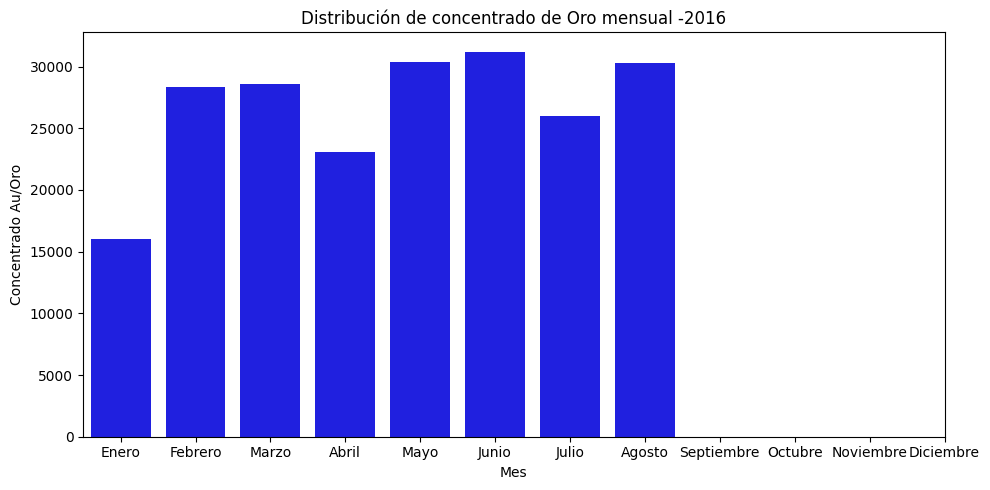

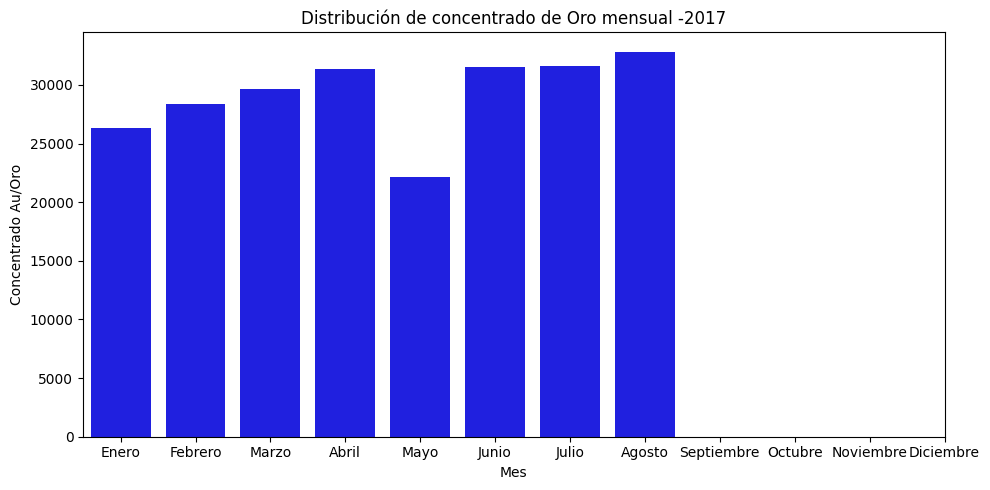

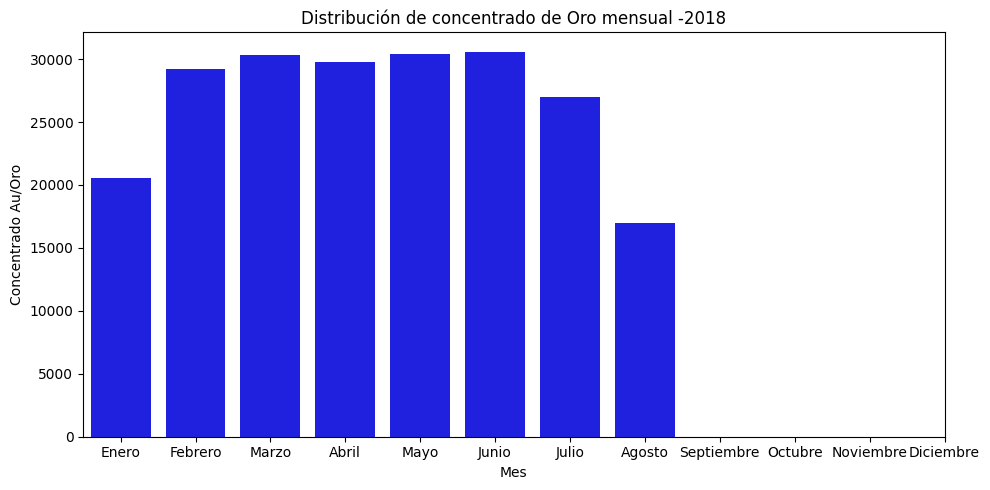

Promedios de extracción concentrados de oro finales por año:


year
2016    26728.16
2017    29234.79
2018    26863.94
Name: final.output.concentrate_au, dtype: float64

El año de mayores concentrados de oro finales fue 2017.
A notar, no hay datos en los ultimos 2 bimestres de cada año de septiembre a diciembre.


In [13]:
#Visualización
#Fecha y recuperación. 
#date y final.output.recovery. Son 3 años así que se harán 3 distribuciones anuales por mes. 

distribucion = datos_entrenamiento #hacer un set de datos con modificaciones. Se le añadirá anotaciones de año y més para graficar distribuciones
distribucion["year"] = distribucion["date"].dt.year
distribucion["month"] = distribucion["date"].dt.month

distribucion_por_año_y_mes = distribucion.groupby(["year", "month"])["final.output.concentrate_au"].sum().reset_index()
#for loop de graficación de distribuciones para los 3 años. 
años = sorted(distribucion_por_año_y_mes["year"].unique())

for año in años: 
    distribucion_año = distribucion_por_año_y_mes[distribucion_por_año_y_mes["year"] == año]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=distribucion_año, x="month", y="final.output.concentrate_au", color="blue")
    plt.title(f"Distribución de concentrado de Oro mensual -{año}")
    plt.xlabel("Mes")
    plt.ylabel("Concentrado Au/Oro")
    plt.xticks(range(0,12), ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio","Julio","Agosto","Septiembre","Octubre", "Noviembre","Diciembre"])
    plt.tight_layout()
    plt.show()

#obtener el promedio anual.
print("Promedios de extracción concentrados de oro finales por año:")
display(distribucion_por_año_y_mes.groupby("year")["final.output.concentrate_au"].mean().round(2)) #Sería útil conocer la unidad de los concentrados.
print("El año de mayores concentrados de oro finales fue 2017.\nA notar, no hay datos en los ultimos 2 bimestres de cada año de septiembre a diciembre.")


Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_au',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_au'],
      dtype='object')
['2016-01' '2016-02' '2016-03' '2016-04' '2017-01' '2017-02' '2017-03'
 '2017-04' '2018-01' '2018-02' '2018-03' '2018-04']
Solo aparecen 4 bimestres por año revisando valores únicos.
1    1896
2    2040
3    2232
4    2161
5    2232
6    2160
7    2232
8    1907
Name: month, dtype: int64
1    1896
2    2040
3    2232
4    2161
5    2232
6    2160
7    2232
8    1907
Name: month, dtype: int64
1    1896
2    2040
3    2232
4    2161
5    2232
6    2160
7    2232
8    1907
Name: month, dtype: int64
En datos de entrenamiento sol

/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


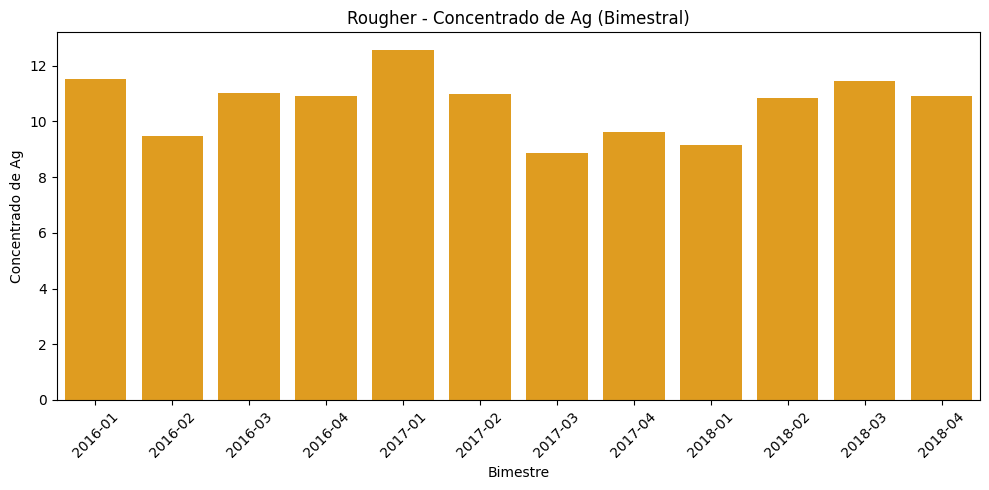

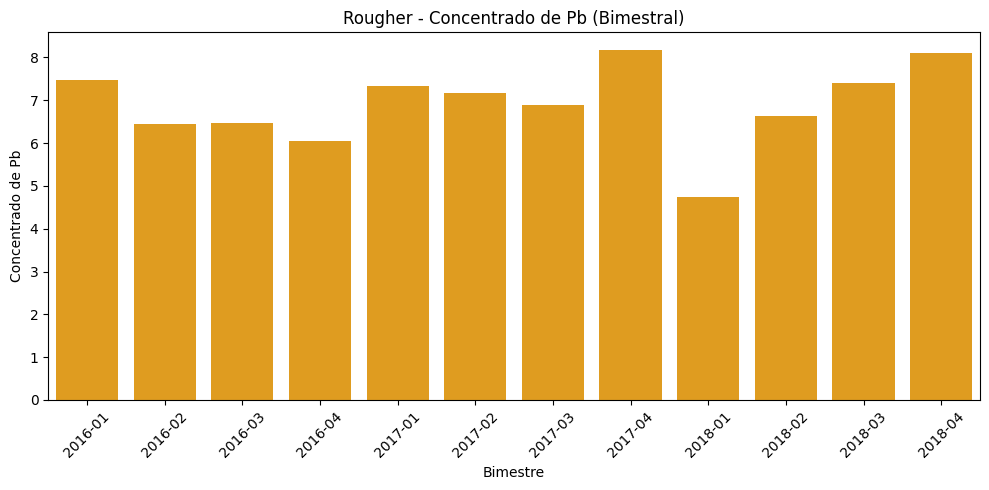

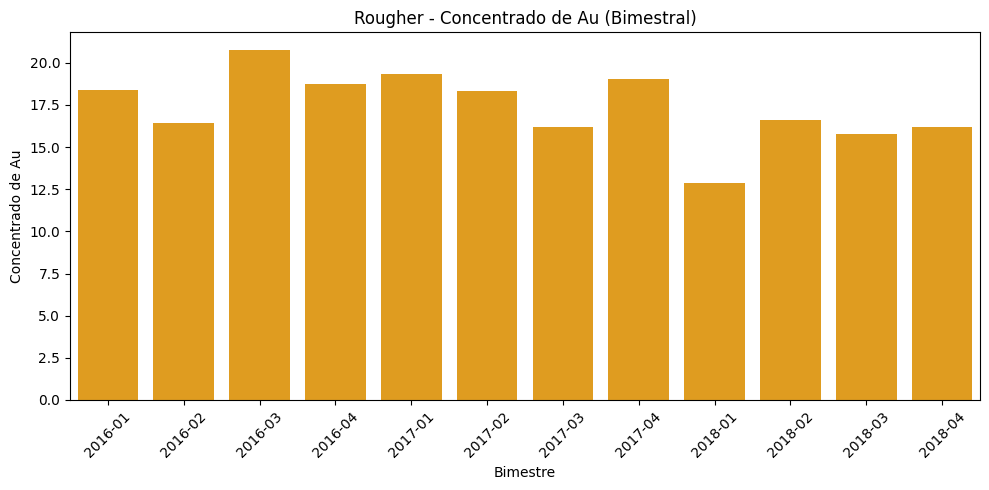

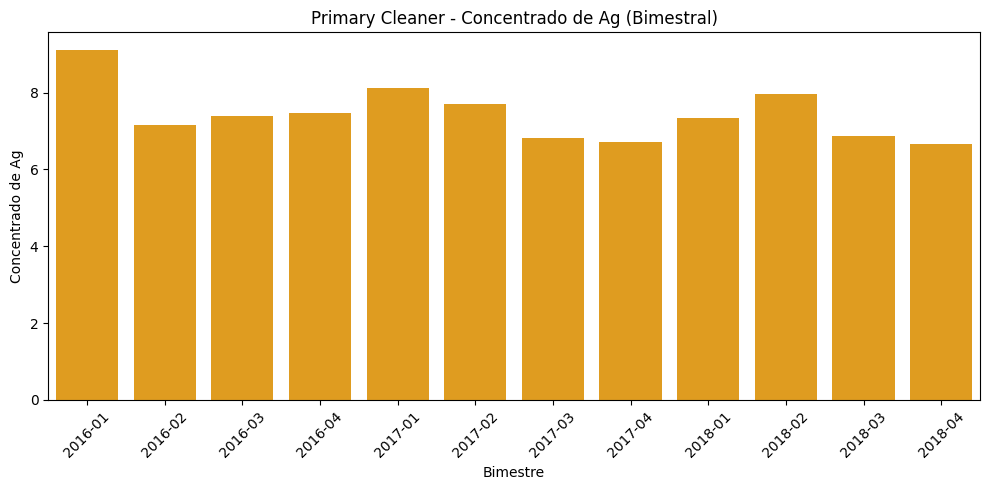

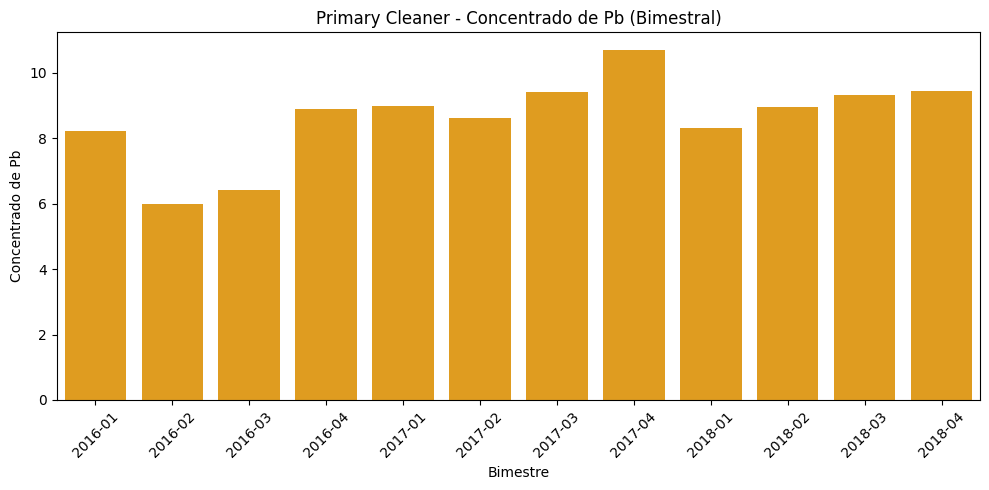

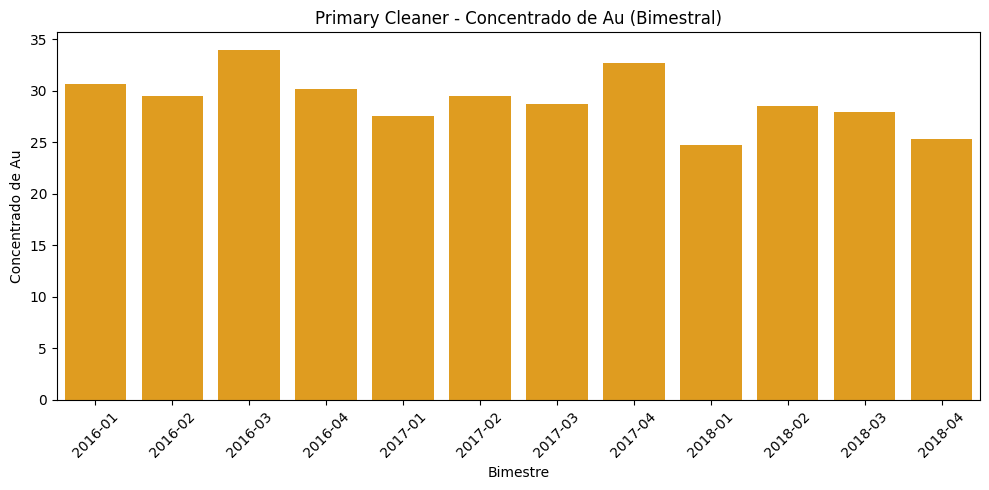

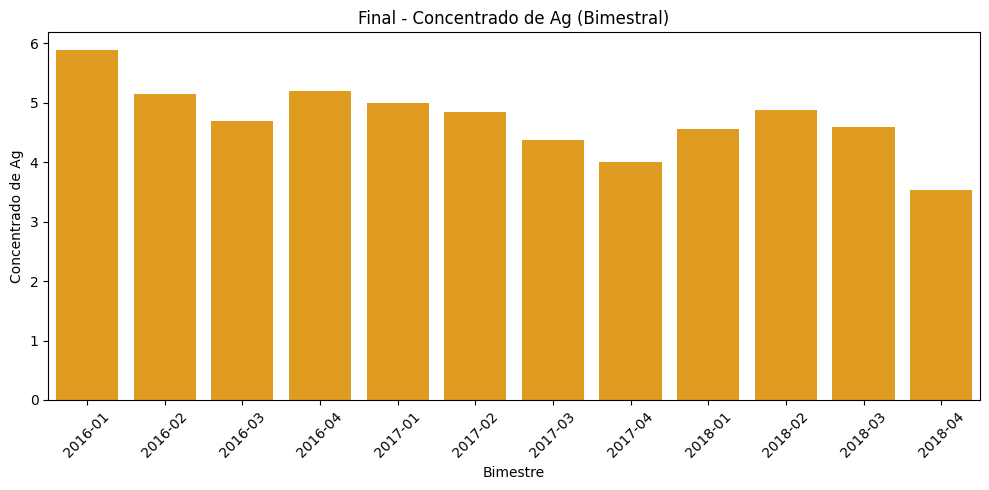

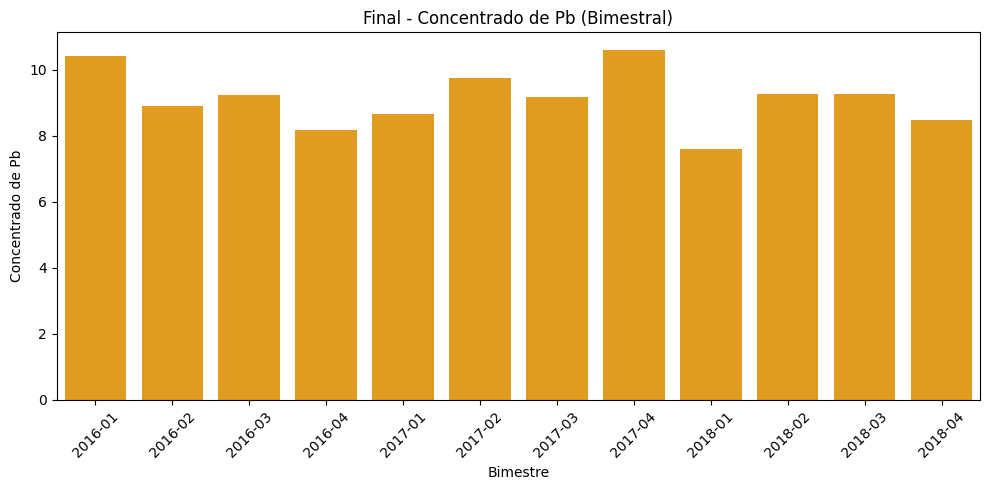

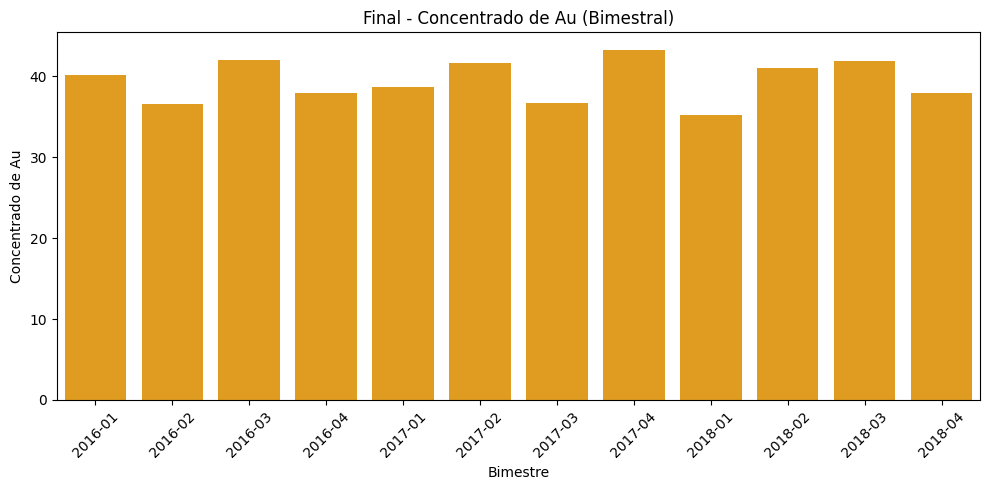

Los concentrados de Au son mayores a trávés de todas las etapas en comparación con Pb y Ag. En el rango del doble en la etapa rougher a triple o cuadruple en las etapas primary_cleaner y final respectivamente.
 Observable con mayor precisión mediante datos estadísticos.


,etapa,tipo,metal,promedio
0,0,rougher,ag,10.580475
1,0,rougher,pb,6.880322
2,0,rougher,au,17.401541
3,1,primary_cleaner,ag,7.422640
4,1,primary_cleaner,pb,8.620294
5,1,primary_cleaner,au,29.164596
6,2,final,ag,4.716907
7,2,final,pb,9.113559
8,2,final,au,39.467217


In [14]:
#Comparación de cambios en concentración de metales (Au, Ag, Pb) en función de la etapa de purificación. Rougher, primary cleaner, secondary cleaner, final. 
#Selección de columnas de concentración de metales en datos de entrenamiento. 
concentracion_metales = datos_entrenamiento.filter(regex="au|ag|pb|date")
concentracion_metales = concentracion_metales.loc[:, ~concentracion_metales.columns.str.contains("tail|calculation")] #Eliminar columnas de calculaciones o colas para enfocarnos en observar los concentrados.
print(concentracion_metales.columns) 
#no hay columnas de secondary_cleaner. Se revisó en las columnas de datos de entrenamiento y no existen esos datos. Hay datos rougher, primary_cleaner, final. 

#División de datos en etapas. 
mask_rougher = concentracion_metales.columns.str.contains("rougher|date") #Se toman columnas relacionadas con la etapa deseada y el punto temporal. 
mask_primary = concentracion_metales.columns.str.contains("primary|date")
mask_final =  concentracion_metales.columns.str.contains("final|date")


concentracion_rougher = concentracion_metales.loc[:, mask_rougher]
concentracion_primary = concentracion_metales.loc[:, mask_primary]
concentracion_final = concentracion_metales.loc[:, mask_final]
concentraciones_etapas = [concentracion_rougher, concentracion_primary, concentracion_final]

#procesar las fechas
for etapa in concentraciones_etapas:
    etapa.loc[:,"year"] = etapa["date"].dt.year
    etapa.loc[:,"month"] = etapa["date"].dt.month
    etapa.loc[:,"bimestre"] = ((etapa["month"] - 1) // 2) + 1
    #agrupo por bimestres sin ordenar por año. Entonces se usaron los años para ordenar.
    etapa.loc[:,"año_bimestre"] = etapa["year"].astype(str) + "-" + etapa["bimestre"].astype(str).str.zfill(2)
    
#Faltan bimestres en los gráficos. Exploración de los bimestres. 
 # Mostrar los bimestres únicos en la etapa para verificar que todos estén cubiertos
print(etapa["año_bimestre"].unique())
print("Solo aparecen 4 bimestres por año revisando valores únicos.")

for etapa in concentraciones_etapas:
    print(etapa["month"].value_counts().sort_index())

print("En datos de entrenamiento solo hay reportes de datos en los primeros 4 bimestres de cada año.")    

nombres_etapa = {
    "rougher": "Rougher",
    "primary_cleaner": "Primary Cleaner",
    "final": "Final"
}
nombres_metal = {"au": "Au", "ag": "Ag", "pb": "Pb"}
metales = ["ag", "pb", "au"]
for etapa in concentraciones_etapas: #Iterar para generar todos los gráficos de distribución de concentrados a través del tiempo por metal. 
    for metal in metales:
        for tipo in nombres_etapa.keys():
            nombre_columna = f"{tipo}.output.concentrate_{metal}"
            if nombre_columna in etapa.columns:  
                #etapa_agrupado_bimestral = etapa.groupby("bimestre")[nombre_columna].mean().reset_index()
                etapa_agrupado_bimestral = etapa.groupby("año_bimestre")[nombre_columna].mean().reset_index()
                etapa_agrupado_bimestral = etapa_agrupado_bimestral.sort_values(by="año_bimestre")
                plt.figure(figsize=(10,5))
                sns.barplot(data=etapa_agrupado_bimestral, x="año_bimestre", y=nombre_columna, color="orange")
                plt.title(f"{nombres_etapa[tipo]} - Concentrado de {nombres_metal[metal]} (Bimestral)")
                plt.xlabel("Bimestre")
                plt.ylabel(f"Concentrado de {nombres_metal[metal]}")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show() 
                
#Conclusiones de las distribuciones
print("Los concentrados de Au son mayores a trávés de todas las etapas en comparación con Pb y Ag. En el rango del doble en la etapa rougher a triple o cuadruple en las etapas primary_cleaner y final respectivamente.\n Observable con mayor precisión mediante datos estadísticos.")

#Obtener promedios de concentrado en tablas para ver las concentraciones con estadísticos. 
promedios_concentracion = []

for idx, etapa in enumerate(concentraciones_etapas):
    for tipo in nombres_etapa.keys():
        for metal in metales:
            nombre_columna = f"{tipo}.output.concentrate_{metal}"
            if nombre_columna in etapa.columns:
                promedio = etapa[nombre_columna].mean()
                promedios_concentracion.append({
                    'etapa': idx,
                    'tipo': tipo,
                    'metal': metal,
                    'promedio': promedio
                })

df_promedios = pd.DataFrame(promedios_concentracion)
display(df_promedios)

#Encontrar la comparación con los datos de prueba. A los datos de prueba le faltan columnas esenciales. Solamente tiene materia de entrada para comparar las distribuciones podría ser solo de los valores de entrada o conseguir los datos con predicción e ingeniería de datos. 
#Valores predecidos no reales.
            

Seguimiento: Comunicar con proveedor de datos sobre la escala empleada de los materiales o concentrados. En que unidad de medición se encuentran. 

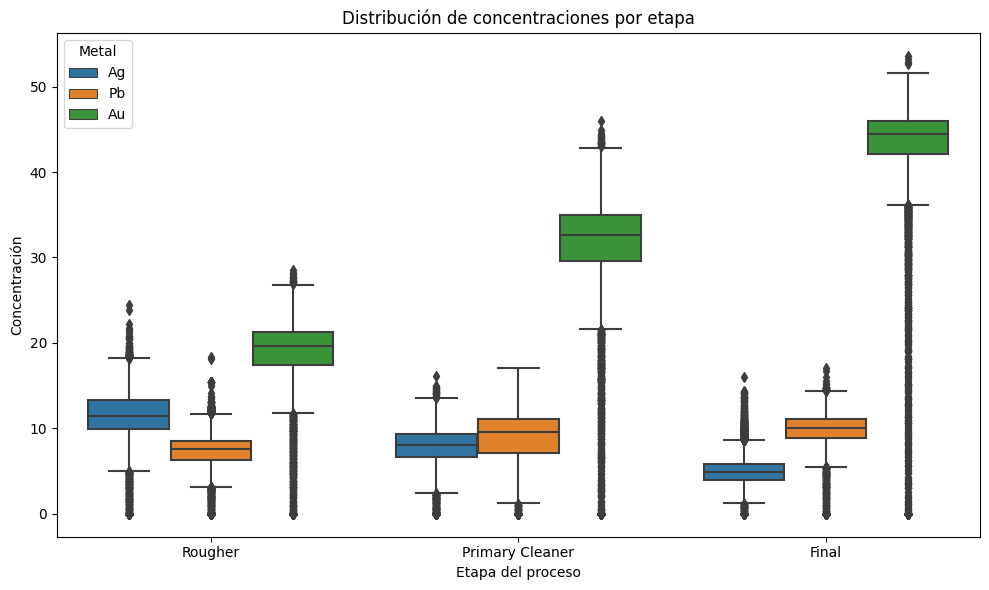

El gráfico de distribución de caja nos hace conocer los datos que no siguen la tendencia central. Para reconocer que es posible que haya datos que cambian el promedio por ser extremos. 
En ocasiones los más externos son removidos para aumentar el poder predictivo de modelos de regresión. 
En oro en etapa primaria y final se encuentra un mayor rango visible sobre todo en valores menores a los centrales.


In [15]:
#Boxplot para revisar presencia de outliers o datos extremos.
data_boxplot = []

for etapa_idx, etapa in enumerate(concentraciones_etapas):
    for tipo in nombres_etapa.keys():
        if tipo not in etapa.columns.str.cat(sep=" "):
            continue
        for metal in metales:
            nombre_columna = f"{tipo}.output.concentrate_{metal}"
            if nombre_columna in etapa.columns:
                df_temp = etapa[[nombre_columna]].copy()
                df_temp = df_temp.dropna()
                df_temp["Etapa"] = nombres_etapa[tipo]
                df_temp["Metal"] = nombres_metal[metal]
                df_temp = df_temp.rename(columns={nombre_columna: "Concentración"})
                data_boxplot.append(df_temp)

df_boxplot = pd.concat(data_boxplot, ignore_index=True)

# Orden personalizado de etapas
etapas_ordenadas = ["Rougher", "Primary Cleaner", "Final"]
df_boxplot["Etapa"] = pd.Categorical(df_boxplot["Etapa"], categories=etapas_ordenadas, ordered=True)

# Plot general
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot, x="Etapa", y="Concentración", hue="Metal")
plt.title("Distribución de concentraciones por etapa")
plt.xlabel("Etapa del proceso")
plt.ylabel("Concentración")
plt.legend(title="Metal")
plt.tight_layout()
plt.show()

print("El gráfico de distribución de caja nos hace conocer los datos que no siguen la tendencia central. Para reconocer que es posible que haya datos que cambian el promedio por ser extremos. \nEn ocasiones los más externos son removidos para aumentar el poder predictivo de modelos de regresión. \nEn oro en etapa primaria y final se encuentra un mayor rango visible sobre todo en valores menores a los centrales.")

In [16]:
#Preprocesamiento de datos prueba
x_test = datos_prueba.drop(columns=["date"]) #solo valores numericos. No datetime
x_test_imputado = knn_imputer.fit_transform(x_test)

x_test = pd.DataFrame(x_test_imputado, columns=x_test.columns)
print(x_test.info()) #Remoción de nulos. Datos preparados para predecir el objetivo: final.output.recovery

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5856 non-null   float64
 10  primary_clea

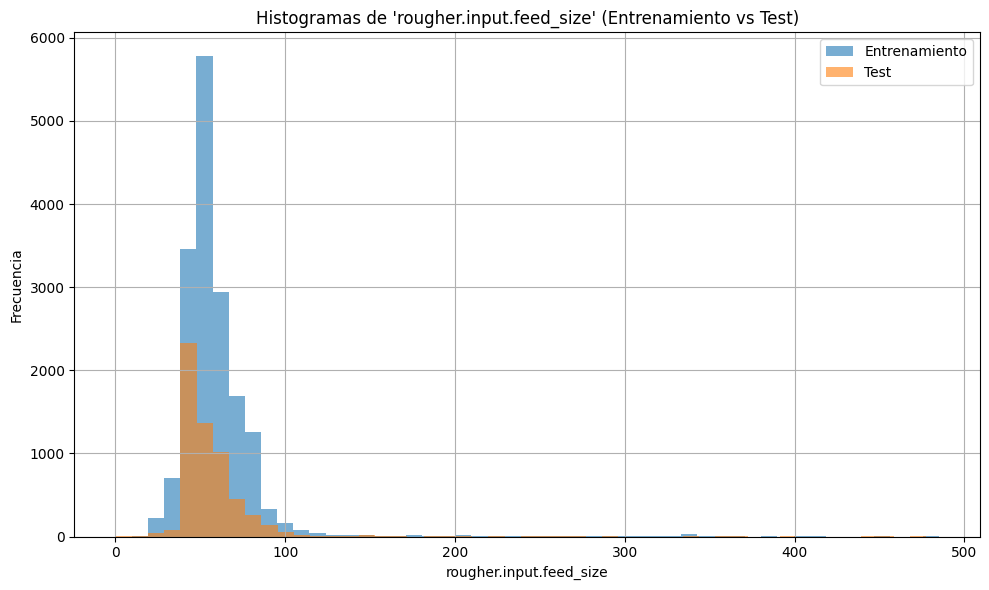

Las distribuciones de materia de entrada entre datos de entrenamiento y prueba son parecidas, se concentran las frecuencias en los mismos valores. 
Por otro lado, hay algunos datos extremos que extienden el eje y griega.


In [17]:
#Distribución de rougher.input.feed_size entre información de entrenamiento y prueba. 
#Data de entrenamiento
datos_entrenamiento_imputados_y_ordenados["rougher.input.feed_size"]
#Data de test
x_test["rougher.input.feed_size"]

#Graficar la distribución 
plt.figure(figsize=(10, 6))

plt.hist(
    datos_entrenamiento_imputados_y_ordenados["rougher.input.feed_size"].dropna(),
    bins=50,
    alpha=0.6,
    label="Entrenamiento"
)

plt.hist(
    x_test["rougher.input.feed_size"].dropna(),
    bins=50,
    alpha=0.6,
    label="Test"
)

plt.xlabel("rougher.input.feed_size")
plt.ylabel("Frecuencia")
plt.title("Histogramas de 'rougher.input.feed_size' (Entrenamiento vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Las distribuciones de materia de entrada entre datos de entrenamiento y prueba son parecidas, se concentran las frecuencias en los mismos valores. \nPor otro lado, hay algunos datos extremos que extienden el eje y griega.")

In [18]:
#Remoción de datos extremos
def detectar_outliers_iqr(df, columna):
    """
    Detecta outliers por el método del rango intercuartílico (IQR).
    
    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene los datos.
    columna (str): El nombre de la columna a analizar.

    Retorna:
    dict: Un diccionario con los outliers por debajo del piso y por encima del techo.
    """
    # Asegurarse de que la columna existe en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    
    # Calcular Q1 (percentil 25) y Q3 (percentil 75)
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Limites inferior (piso) y superior (techo)
    piso = Q1 - 1.5 * IQR
    techo = Q3 + 1.5 * IQR


    return {
        'piso': piso,
        'techo': techo}
    
#Función para filtrar los outliers detectados
def filtrar_outliers(df, columna):
    limites = detectar_outliers_iqr(df, columna)
    return df[(df[columna] >= limites['piso']) & (df[columna] <= limites['techo'])] #Mantiene los valores que respetan el rango interquartílico de 1.5 menor y mayor al 25% y 75% de los valores. 



In [19]:
#Filtrar las columnas que no son relevantes para remoción de datos extremos. (así se previene pérdida de datos) 
#Se puede aumentar la filtración para considerar menos columnas de remoción de datos extremos si se busca preservar mayor cantidad de datos de entrenamiento.

columnas_a_filtrar = datos_entrenamiento_imputados_y_ordenados.columns[
    ~datos_entrenamiento_imputados_y_ordenados.columns.str.contains('floatbank|calculation')
]
#filtrar los outliers de los datos de entrenamiento imputados

outlier_indices = set() # Guardar índices de filas que tengan outliers en cualquier columna

for col in columnas_a_filtrar:
    limites = detectar_outliers_iqr(datos_entrenamiento_imputados_y_ordenados, col)
    piso = limites['piso']
    techo = limites['techo']
    
    # Detectar filas que están fuera de límites
    outliers = datos_entrenamiento_imputados_y_ordenados[
        (datos_entrenamiento_imputados_y_ordenados[col] < piso) |
        (datos_entrenamiento_imputados_y_ordenados[col] > techo)
    ].index
    
    outlier_indices.update(outliers)

# Ahora quitamos las filas con outliers
df_entrenamiento_sin_outliers = datos_entrenamiento_imputados_y_ordenados.drop(index=outlier_indices)

print(df_entrenamiento_sin_outliers.shape)
print(df_entrenamiento_sin_outliers.info())  #Sin nulos y sin datos extremos se puede comparar con boxplot meramente se deberían ver valores menos extremos. 
                                             #Reducciones en el eje Y para las mediciones de concentrados de cada metal. Se puede ver en un boxplot o con comparación de rangos (mínimos y máximos de las columnas relevantes.)

print("Descripción estadística de columnas en datos entrenamiento:")
print(datos_entrenamiento.describe())
print("\nDescripción estadística de columnas en datos entrenamiento imputados y sin outliers:")
print(df_entrenamiento_sin_outliers.describe())

print("De las descripciones se puede observar como las columnas de concentrados ejemplo final.output.concentrate_ag varían entre la remoción de datos extremos (8.5 valor máximo) y sin la remoción (16), \nde forma similar los valores menores fueron reducidos. Sin embargo, el número de registros es de tan solo 9235 en lugar de 16860. Casi se pierde la mitad de los datos. Se puede observar si este paso es valioso en el poder de predicción del modelo de regresión.")
#Aplicar solo a columnas de concentrados, colas y recuperación. 

(9100, 87)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 0 to 16850
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                9100 non-null   datetime64[ns]
 1   final.output.concentrate_ag                         9100 non-null   float64       
 2   final.output.concentrate_pb                         9100 non-null   float64       
 3   final.output.concentrate_sol                        9100 non-null   float64       
 4   final.output.concentrate_au                         9100 non-null   float64       
 5   final.output.recovery                               9100 non-null   float64       
 6   final.output.tail_ag                                9100 non-null   float64       
 7   final.output.tail_pb                                9100 non-null   float64       
 

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                  9100.000000                  9100.000000   
mean                      4.994012                    10.392731   
std                       1.080762                     1.299381   
min                       2.272034                     5.459754   
25%                       4.149723                     9.515297   
50%                       4.850818                    10.488838   
75%                       5.683954                    11.296772   
max                       8.604320                    14.420071   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                   9100.000000                  9100.000000   
mean                       9.304572                    44.793707   
std                        2.260995                     2.177085   
min                        1.993871                    36.041221   
25%                        7.763797                    4

In [20]:
#Función EAM o Smape. Función a utilizar para evaluar los modelos de regresión realizados a continuación. 
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Manejar divisiones por cero
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

In [21]:
#El objetivo es conocer final.output.recovery de los datos de prueba. En todo caso generarlos o predecirlos a partir de los datos de entrenamiento. 
#Como no se conocen los valores de múltiples columnas de pruebas la validez del modelo se explora usando validación cruzada y métricas de precisión de la regresión como R2, EAM o smape. 

#Modelo sin datos extremos
df_entrenamiento_sin_outliers

#Generar el modelo
modelo = LinearRegression() 

#Eliminar la columna date
df_entrenamiento_sin_outliers_numerical = df_entrenamiento_sin_outliers.drop(columns=["date"])


#Al entrenar un modelo. Las columnas deben coincidir con aquellas de los datos a ser predichos por lo tanto se puede hacer un código para que se consideren solamente los datos en común. 
x_train = df_entrenamiento_sin_outliers_numerical.loc[:, df_entrenamiento_sin_outliers.columns.intersection(x_test.columns)]
x_train_objetivo = df_entrenamiento_sin_outliers["final.output.recovery"]
x_train = x_train.loc[:, x_test.columns] #mismo orden de columnas. 

modelo.fit(x_train, x_train_objetivo)

predict = modelo.predict(x_test) 
#Métricas del modelo/Evaluación

#Validación cruzada con smape. 
kf = KFold(n_splits=5, shuffle=True, random_state=54321)
puntajes1_smape = cross_val_score(modelo, x_train, x_train_objetivo, cv=kf, scoring=smape_scorer)

print(f"Puntaje SMAPE por validación cruzada del modelo alimentado sin datos extremos: {-puntajes1_smape.mean():.2f}%")
print(f"El Poder predictivo del modelo 1 llegó a generar resultados de recuperación de oro con variación promedio de tan solo {-puntajes1_smape.mean():.2f}%. Un modelo bastante bueno. \nLos resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.")
 


Puntaje SMAPE por validación cruzada del modelo alimentado sin datos extremos: 5.38%
El Poder predictivo del modelo 1 llegó a generar resultados de recuperación de oro con variación promedio de tan solo 5.38%. Un modelo bastante bueno. 
Los resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.


In [22]:
#Regresor de rougher output recovery
x_train_objetivo2 = df_entrenamiento_sin_outliers["rougher.output.recovery"]
modelo_rougher = LinearRegression()

modelo_rougher.fit(x_train, x_train_objetivo2)
predict_rougher = modelo_rougher.predict(x_test)

#Metricas
#Validación cruzada con smape. 
kf = KFold(n_splits=5, shuffle=True, random_state=54321)
puntajes_rougher_smape = cross_val_score(modelo_rougher, x_train, x_train_objetivo, cv=kf, scoring=smape_scorer)

print(f"Puntaje SMAPE por validación cruzada del modelo alimentado sin datos extremos para predecir rougher.output.recovery: {-puntajes_rougher_smape.mean():.2f}%")
print(f"El modelo predice rougher output recovery con  {-puntajes_rougher_smape.mean():.2f} de variación.")

#Smape promedio ponderado de regresores lineales. 
smape_promedio_ponderado_regresores_lineales = ((-puntajes1_smape.mean()*.75) + (-puntajes_rougher_smape.mean()*.25))/2
print(f"\nSmape Promedio Ponderado de regresores lineales: {smape_promedio_ponerdado_regresores_lineales}")


Puntaje SMAPE por validación cruzada del modelo alimentado sin datos extremos para predecir rougher.output.recovery: 5.38%
El modelo predice rougher output recovery con  5.38 de variación.


In [23]:
#Modelo para predecir output.recovery con mayor cantidad de muestra. Mantiene datos extremos. 
datos_entrenamiento_imputados_y_ordenados

#Generar el modelo 
modelo2 = LinearRegression()

datos_entrenamiento_imputados = datos_entrenamiento_imputados_y_ordenados.drop(columns=["date"])
x_train2 = datos_entrenamiento_imputados.loc[:, datos_entrenamiento_imputados.columns.intersection(x_test.columns)] #Entrenamiento con datos imputados pero sin remoción de valores extremos.
x_train2_objetivo = datos_entrenamiento_imputados_y_ordenados["final.output.recovery"]
modelo2.fit(x_train2, x_train2_objetivo)

predict2 = modelo2.predict(x_test)

#Métricas del modelo 

#validación cruzada con smape. 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
puntajes2_smape = cross_val_score(modelo2, x_train2, x_train2_objetivo, cv=kf, scoring=smape_scorer)

print(f"Puntaje SMAPE del modelo alimentado con todos los datos de entrenamiento: {-puntajes2_smape.mean():.2f}%")
print("El Poder predictivo del modelo 2 llegó a generar resultados de recuperación de oro con variación promedio de tan solo 10.86%. Un modelo bueno. \nLos resultados serán cercanos a lo real, al rededor de 11% de variación de la recuperación real de oro. Aquí se demuestra que retirar los datos extremos apoyó en los resultados del modelo.")

Puntaje SMAPE del modelo alimentado con todos los datos de entrenamiento: 10.92%
El Poder predictivo del modelo 2 llegó a generar resultados de recuperación de oro con variación promedio de tan solo 10.86%. Un modelo bueno. 
Los resultados serán cercanos a lo real, al rededor de 11% de variación de la recuperación real de oro. Aquí se demuestra que retirar los datos extremos apoyó en los resultados del modelo.


Revisión de modelos alternos: RandomForestRegressor

In [24]:
#Buscar hiperparámetros para los datos para la predicción de recuperacion final. RandomizedSearchCV 

#Definir la red de hiperparámetros de forma aleatorizada. 
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
} #16 combinaciones de valores
#Buscar los parámetros
random_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state = 54321), param_grid=param_grid, cv=2, scoring='neg_mean_absolute_error')
#Se toma una muestra aleatoria 0.3 para reducir el uso de recursos computacionales ya que hay casi 17K registros.
x_muestra, _, x_muestra_objetivo, _ = train_test_split(
    x_train, x_train_objetivo, train_size=0.3, random_state=42
)
random_search.fit(x_muestra, x_muestra_objetivo)

#Imprimir los mejores parámetros para los datos dados. 
print("Mejores parámetros:", random_search.best_params_) 

Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [25]:
#Buscar hiperparámetros para los datos para la predicción de recuperación rougher. RandomizedSearchCV 

#Definir la red de hiperparámetros de forma aleatorizada. 
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
}
#Buscar los parámetros
random_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state = 54321), param_grid=param_grid, cv=2, scoring=smape_scorer)
#Muestra para reducir recursos computacionales 
x_muestra, _, x_muestra_objetivo2, _ = train_test_split(
    x_train, x_train_objetivo2, train_size=0.3, random_state=42
)
random_search.fit(x_muestra, x_muestra_objetivo2)
#Imprimir los mejores parámetros para los datos dados. 
print("Mejores parámetros:", random_search.best_params_)
#Como el orden de las funciones genera reportes. Aunque se llamen igual ya habrán reportado con los valores previos. 

Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [26]:
#Predicción por RandomForestRegressor
#Predicción de variable 1
#Preparar los datos
x_train  
x_train_objetivo #preparados en el modelo de regresión lineal.
#Generar el modelo
#búsqueda de mejores hiperparámetros
model_forest_final = RandomForestRegressor(max_depth= 5, min_samples_leaf=5, min_samples_split = 5, n_estimators = 100)
#Entrenado de modelo 
model_forest_final.fit(x_train, x_train_objetivo)
predict_forest = model_forest_final.predict(x_test) 
#Métricas del modelo/Evaluación

#Validación cruzada con smape. 
kf = KFold(n_splits=5, shuffle=True, random_state=54321)
puntajes3_smape = cross_val_score(model_forest_final, x_train, x_train_objetivo, cv=kf, scoring=smape_scorer)

print(f"Puntaje SMAPE de regresión por bosque aleatorio en validación cruzada del modelo alimentado sin datos extremos al predecir recuperación final: {-puntajes3_smape.mean():.2f}%")
print(f"El Poder predictivo de regresión por bosque aleatorio de recuperacion de oro final generó resultados con variación promedio de tan solo {-puntajes3_smape.mean():.2f}%. Un modelo bastante bueno. \nLos resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.")


Puntaje SMAPE de regresión por bosque aleatorio en validación cruzada del modelo alimentado sin datos extremos al predecir recuperación final: 5.01%
El Poder predictivo de regresión por bosque aleatorio de recuperacion de oro final generó resultados con variación promedio de tan solo 5.01%. Un modelo bastante bueno. 
Los resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.


In [27]:
#Predicción de variable 2: recuperación en rougher o flotación
#Preparar los datos
x_train 
x_train_objetivo2 = df_entrenamiento_sin_outliers["rougher.output.recovery"]
#Generar el modelo 
model_forest_rougher = RandomForestRegressor(max_depth= 5, min_samples_leaf=5, min_samples_split = 5, n_estimators = 100)
#Entrenado de modelo 
model_forest_rougher.fit(x_train, x_train_objetivo)
predict_forest_rougher = model_forest_final.predict(x_test)
#Metricas del modelo 
#Validación cruzada con smape. 
kf = KFold(n_splits=5, shuffle=True, random_state=54321)
puntajes4_smape = cross_val_score(model_forest_rougher, x_train, x_train_objetivo2, cv=kf, scoring=smape_scorer)

print(f"Puntaje SMAPE de regresión por bosque aleatorio en validación cruzada del modelo alimentado sin datos extremos al predecir recuperación rougher o de flotado es: {-puntajes4_smape.mean():.2f}%")
print(f"El Poder predictivo de regresión por bosque aleatorio de recuperacion de oro final generó resultados con variación promedio de tan solo {-puntajes4_smape.mean():.2f}%. Un modelo bastante bueno. \nLos resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.")

#SMAPE resultante de predicción de mis dos variables por regresión con modelo de bosque aleatorio
smape_promedio_bosque = ((-puntajes3_smape.mean()*.75) + (-puntajes4_smape.mean()*.25))/2 #puntajes 3 proviene de smape final y puntajes 4 de rougher. 
print(f"Smape promedio: {smape_promedio_bosque}")

Puntaje SMAPE de regresión por bosque aleatorio en validación cruzada del modelo alimentado sin datos extremos al predecir recuperación rougher o de flotado es: 3.12%
El Poder predictivo de regresión por bosque aleatorio de recuperacion de oro final generó resultados con variación promedio de tan solo 3.12%. Un modelo bastante bueno. 
Los resultados serán muy cercanos a lo real, resaltando de nuevo: al rededor de 5% de variación.
Smape promedio: 4.061290413998183


In [28]:
#Adjuntar los datos de recuperación de oro predecidos a los datos de prueba. 
#Hacer una copia de los datos para no alterar los originales
datos_prueba_con_predicciones_de_recuperacion = datos_prueba.copy() 

#Generar los datos rougher.output_recovery mediante predicción y adjuntarlos a la copia de los datos de prueba.
recuperacion_rougher_de_datos_de_prueba = pd.Series(predict_forest_rougher, index=datos_prueba.index)
datos_prueba_con_predicciones_de_recuperacion["rougher.output_recovery_predicted"] = recuperacion_rougher_de_datos_de_prueba


#Datos de predicción de recuperación de oro final. 
recuperacion_de_oro_de_datos_de_prueba = pd.Series(predict_forest, index=datos_prueba.index) 
datos_prueba_con_predicciones_de_recuperacion["final.output_recovery_predicted"] = recuperacion_de_oro_de_datos_de_prueba

print("Primeras 5 filas del set de datos de prueba. Al final se encuentra la predicción de oro recuperado:")
display(datos_prueba_con_predicciones_de_recuperacion.head())

#Exploración de tendencia central. Promedio de recuperación del set de prueba. 
print(datos_prueba_con_predicciones_de_recuperacion["final.output_recovery_predicted"].mean())
print("Los datos de recuperación de oro predecidos de los datos de prueba tienen una tendencia central muy similar a los datos de entrenamiento. Ambos en la unidad de 68.")

promedio_datos_rougher_predecidos = datos_prueba_con_predicciones_de_recuperacion["rougher.output_recovery_predicted"].mean()
print(f"El promedio rougher es {promedio_datos_rougher_predecidos}.")

#Comparación con el promedio rougher de datos de entrenamiento
promedio_rougher_entrenamiento = df_entrenamiento_sin_outliers["rougher.output.recovery"].mean()
print(f"Promedio rougher entrenamiento {promedio_rougher_entrenamiento}")

print("\nAmbos datos de entrenamiento y prueba tienen medidas centrales cercanas en los valores predecidos y reales con pequeñas varianzas y concordantes con las distribuciones. Para recuperación rougher y recuperación de oro final tienen la misma unidad de entero 84 y 68 respectivamente.")

Primeras 5 filas del set de datos de prueba. Al final se encuentra la predicción de oro recuperado:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output_recovery_predicted,final.output_recovery_predicted
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,71.050846,71.050846
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,70.978102,70.978102
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,70.944406,70.944406
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,71.002413,71.002413
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,71.032194,71.032194


68.3096541312366
Los datos de recuperación de oro predecidos de los datos de prueba tienen una tendencia central muy similar a los datos de entrenamiento. Ambos en la unidad de 68.
El promedio rougher es 68.3096541312366.
Promedio rougher entrenamiento 84.89035994227663

Ambos datos de entrenamiento y prueba tienen medidas centrales cercanas en los valores predecidos y reales con pequeñas varianzas y concordantes con las distribuciones. Para recuperación rougher y recuperación de oro final tienen la misma unidad de entero 84 y 68 respectivamente.


Conclusiones

Se realizó el procesamiento de datos involucrando manejo de nulos (necesarios de remover para el funcionamiento de modelado por aprendizaje articial). 

Se observó la distribución de concentrados por metal de forma gráfica y estadística (gráficos de barras, boxplot y comparación de promedios) a través de las etapas de flotación, limpieza primaria y final. 

Se realizaron 2 modelos predictivos con métricas de calidad de variación smape de 4.06% o 5.01% y 3.11% respectivamente para recuperación final y recuperación en flotado o rougher. Ambos con predicción cercanas a la real. El modelo de regresión por bosque aleatorio superó a los modelos de regresión lineal.

Los mejores resultados de predicción fueron logrados mediante entrenamiento con datos extremos removidos.

Se generaron y presentaron los valores de recuperación de oro final y de flotado del conjunto de datos de prueba y se adjuntaron a los datos de prueba empleando los modelos de mejor desempeño aquellos de regresión por bosque aleatorio. 